In [2]:
# Imports
%load_ext autoreload
%autoreload 2

from loguru import logger
import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

from constants import *
from pygwb.constants import H0
import equations
import redshiftPrior

In [3]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# fontsize = 18
# params = {
#    'axes.labelsize': fontsize,
#    'font.size': fontsize,
#    'legend.fontsize': 12,
#    'xtick.labelsize': fontsize,
#    'ytick.labelsize': fontsize,
#    'axes.titlesize':fontsize,
#    'lines.linewidth':1,  
#    'xtick.direction':'in',
#    'ytick.direction':'in',
#    'font.family':'Serif',
#    'font.serif':'Hoefler Text',
#    'axes.grid':True,
#    'figure.figsize': (6.75, 4),
#    'figure.dpi':250,
#    'mathtext.fontset':'cm'
# }

# for param in params.keys():
#     matplotlib.rcParams[param] = params[param]    

In [4]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 18
# ALWAYS USE figsize = (3.375, X) for column plots 
# figsize = (6.75, X) for rows 
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 12,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]    

In [5]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Data Simulation Parameters
T_obs = (1/365.25) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
fs = 4096 # sampling rate (in Hz)
fmax = 1024

num_iterations = 10

In [6]:
# Standard Prior Dictionary
# Prior dictionary for priors we *want* to calculate omega_gw for
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

# "Reference" prior dictionary
ref_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# uniform_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
ref_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
ref_priors['chi_1'] = 0
ref_priors['chi_2'] = 0
ref_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp,
                                                                       minimum=0, maximum=z_max, name='redshift')
ref_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del ref_priors['luminosity_distance']
del ref_priors['chirp_mass']

22:15 bilby INFO    : Using aligned spin prior
22:15 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.
22:15 bilby INFO    : Using aligned spin prior
22:15 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [7]:
# Calculate number of injections
def calculate_num_injections(T_obs, priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    return N

zs, p_dz = priors['redshift']._get_redshift_arrays()
N = calculate_num_injections(T_obs, priors)
print(N)

658.3533970255626 1 / yr


In [8]:
def draw_injections(prior_dict, Tobs):
    """
    Figure out how many injections to draw, then
    draw that number of injections

    Parameters
    ----------
    prior_dict : bilby.gw.prior.BBHPriorDict
        bilby prior dictionary
    Tobs : double
        Observation time (yrs)

    Returns
    -------
    injections : dict
        dictionary containing information on injections
    """
    N = calculate_num_injections(T_obs, priors)

    logger.info(f"We are averaging over {N} waveforms for {np.round(Tobs, 3)} years")
    N_inj = np.random.poisson(N.value)
    injections = prior_dict.sample(N_inj)
    injections["signal_type"] = "CBC"
    return injections

def monteCarlo(
    prior_dict,
    # injections,
    Tobs,
    duration=10,
    f_ref=25,
    sampling_frequency=2048,
    approximant="IMRPhenomD",
):
    # Calculate number of injections
    injections = draw_injections(prior_dict, Tobs)

    injections['mass_1'] = injections['mass_1']*(1+injections['redshift'])
    
    # set up waveform generator
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments={
            "waveform_approximant": approximant,
            "reference_frequency": 50,
            "minimum_frequency": 1,
        },
    )  # breaks down at M_tot * (1+z) ~ 1000, according to Xiao-Xiao and Haowen

    # convert to seconds, set up frequency array for waveform

    freqs_psd = waveform_generator.frequency_array
    omega_gw_freq = np.zeros(len(freqs_psd))

    try:
        N_inj = len(injections["geocent_time"]["content"])
    except:
        N_inj = len(injections["geocent_time"])

    # logger.info("Compute the total injected Omega for " + str(N_inj) + " injections")

    # Loop over injections
    for i in tqdm(range(N_inj)):
        inj_params = {}
        # Generate the individual parameters dictionary for each injection
        for k in injections.keys():
            if k == "signal_type":
                continue
            try:
                inj_params[k] = injections[k]["content"][i]
            except:
                inj_params[k] = injections[k][i]

        # Get frequency domain waveform
        polarizations = waveform_generator.frequency_domain_strain(inj_params)

        # Final PSD of the injection
        psd = np.abs(polarizations["plus"]) ** 2 + np.abs(polarizations["cross"]) ** 2

        # Add to Omega_spectrum
        omega_gw_freq += 2 * np.pi**2 * freqs_psd**3 * psd / (3 * H0.si.value**2)

    Tobs_seconds = Tobs * 86400 * 365.25  # years to seconds
    omega_gw_freq *= 2 / Tobs_seconds

    # return freqs_psd, omega_gw_freq, injections
    return freqs_psd.tolist(), omega_gw_freq.tolist()

In [9]:
def calculate_total_rate(priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    return total_sum

def calculate_expected_num_events(T_obs, priors):
    '''
    T_obs : float
        observation time (in seconds)
    priors: bilby.core.prior.PriorDict
        bilby prior dictionary

    Returns:
    --------
    N : float
        Expected number of events in that time
    '''
    rate = calculate_total_rate(priors)
    return T_obs * rate

def get_weights(N_inj, reference_priors, target_priors, zs, m1s, qs):
    """
    get weights that we use to reweight our spectrum
    
    dEdfs : array-like
        array of h+^2 + hx^2 for the reference injectionset
    reference_priors : bilby.core.prior.PriorDict
        bilby prior dictionary for the reference priors
    target_priors : bilby.core.prior.PriorDict
        bilby prior dictionary for the target priors we want to use to calculate Omega_gw
    zs : array-like
        redshift of each injection
    m1s : array-like
        mass1s of each injection
    m2s : array-like
        mass2s of each injection
    qs : mass ratios of each injection
    
    """
    weights = []
    for i in range(N_inj):
        z = zs[i]
        m1 = m1s[i]
        # m2 = m2s[i]
        q = qs[i]
        # Mtot = Mtots[i]
        # M = Ms[i]

        # Probability of drawing {z, m1, m2}
        p_z = target_priors['redshift'].prob(z)
        p_m1 = target_priors['mass_1'].prob(m1)
        p_q = target_priors['mass_ratio'].prob(q)

        pdraw_z = reference_priors['redshift'].prob(z)
        pdraw_m1 = reference_priors['mass_1'].prob(m1)
        pdraw_q = reference_priors['mass_ratio'].prob(q)

        # # Weight calculation
        # r = equations.R_SI(alpha, beta, z, zp, R0)
        # h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
        h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

        wi = (p_z/pdraw_z) * (p_m1/pdraw_m1) * (p_q/pdraw_q)
        weights.append(wi)
    return np.array(weights)

2024-04-01 22:15:29.065 | INFO     | __main__:draw_injections:20 - We are averaging over 658.3533970255626 1 / yr waveforms for 0.0 years
22:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|██████████| 663/663 [00:05<00:00, 131.85it/s]
2024-04-01 22:15:34.183 | INFO     | __main__:draw_injections:20 - We are averaging over 658.3533970255626 1 / yr waveforms for 0.0 years
22:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|██████████| 684/684 [00:04<00:00, 138.57it/s]
2024-04-01 22:15:39.165 | INFO     | __main__:draw_injections:20 - We are averaging over 658.3533970255626 1 / yr waveforms fo

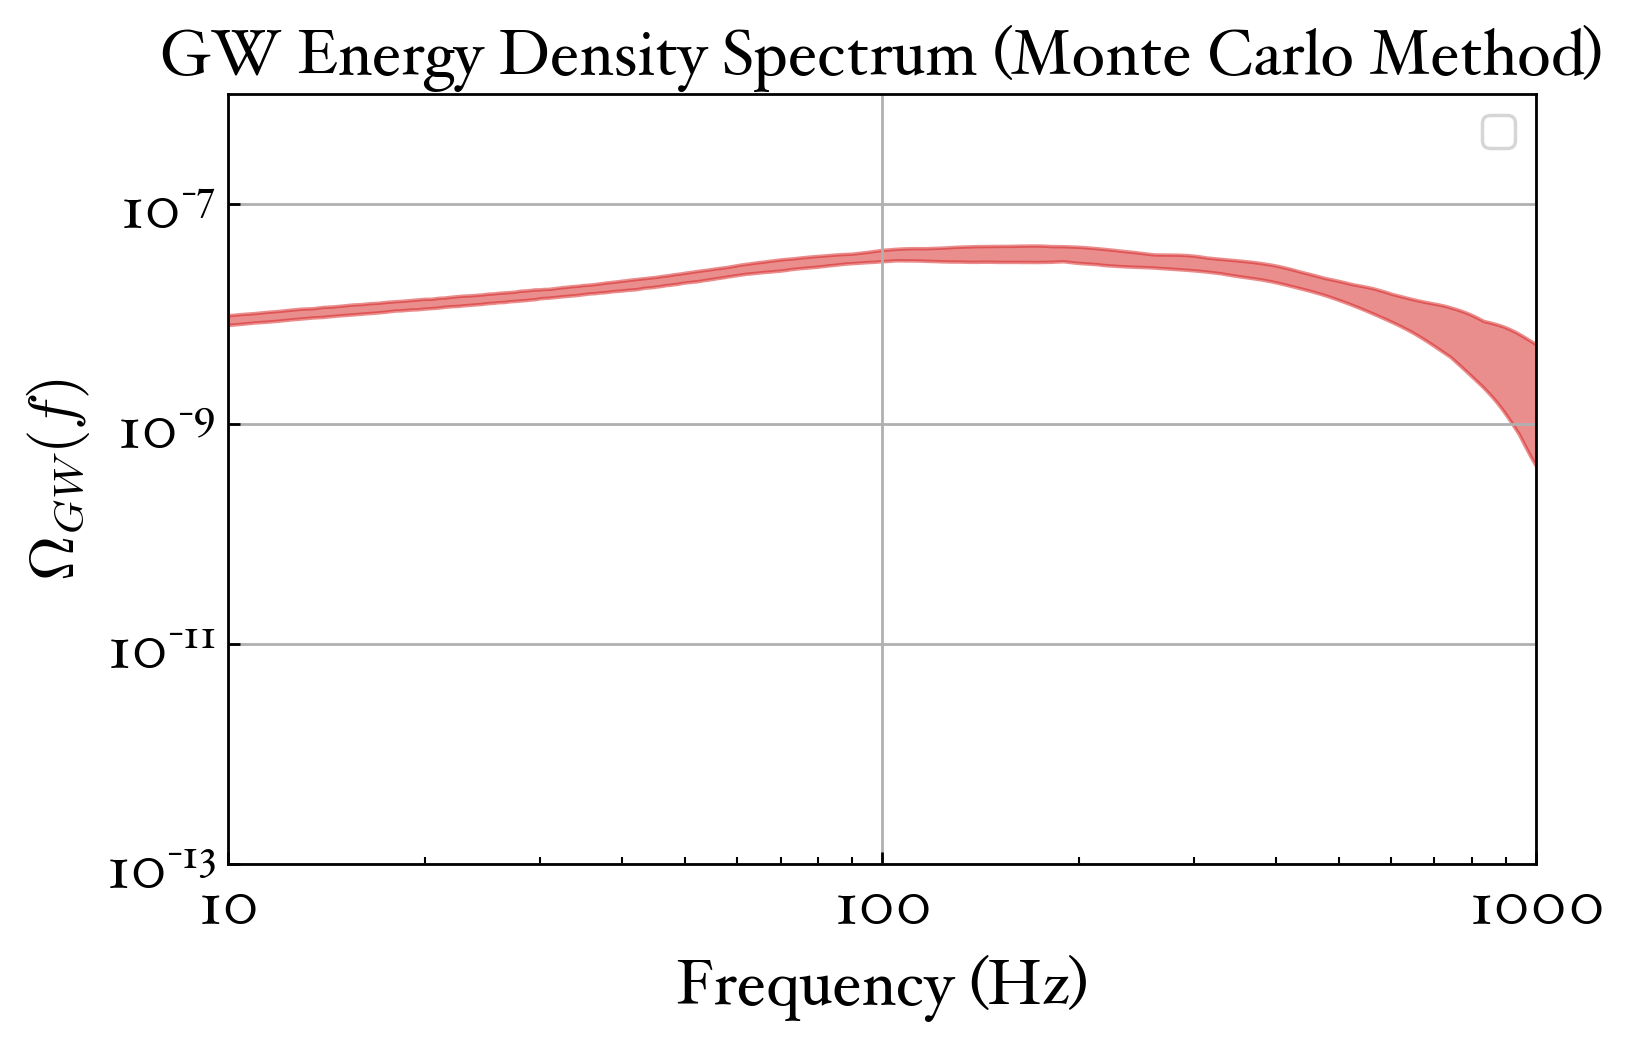

In [10]:
# Regimbau Method
OmegaGW_AR = []
for i in range(num_iterations):
    freqs_psd, omega_gw_freq = monteCarlo(priors, Tobs=T_obs/10, duration=2, f_ref=25, sampling_frequency=fs, approximant='IMRPhenomXPHM')
    OmegaGW_AR.append(omega_gw_freq)

# Plot spectrum
plt.subplots()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_psd, np.percentile(OmegaGW_AR, 5, axis=0), np.percentile(OmegaGW_AR, 95, axis=0), color='#d61c1c', alpha=0.5)

ax.set_xlim(10, 1000)
ax.set_ylim(1e-13,1e-6)
ax.set_title(r'GW Energy Density Spectrum (Monte Carlo Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_39382/1934098292.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


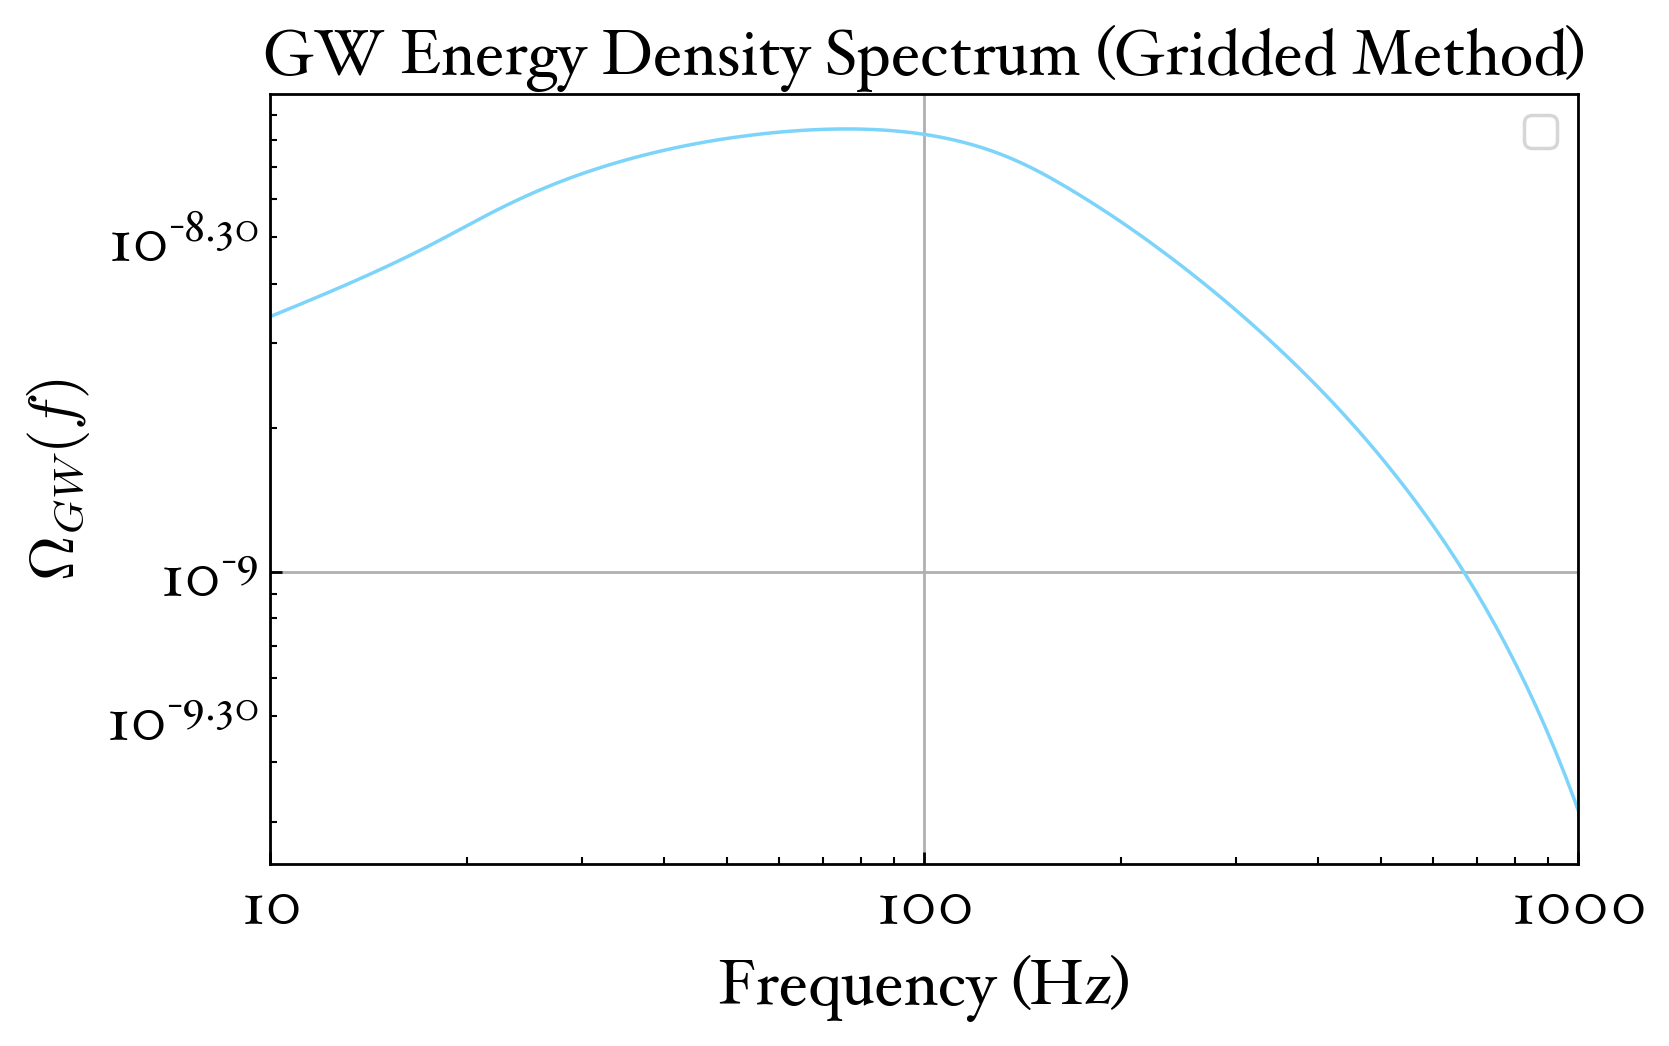

In [11]:
# Gridded Method
# Set up OmegaGW object
inspiralOnly = False
m1_min = BBH_min
m1_max = BBH_max
m2_min = BBH_min
m2_max = BBH_max
minimum_component_mass = BBH_min
maximum_component_mass = BBH_max
omg = OmegaGW_BBH(minimum_component_mass, maximum_component_mass, zs)

# Calculate merger rate
mergerRate = equations.get_R_array(zs, alpha, beta, zp, R0)

# Calculate probability grid
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0], omg.qs_2d.shape[1])) # initialize array
for i in range(omg.m1s_2d.shape[0]): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each q
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1. + omg.qs_2d)) # multiply by the Jacobian

# Limit probabilities to physical masses
probs[omg.m1s_2d < m1_min] = 0
probs[omg.m1s_2d > m1_max] = 0
probs[omg.m2s_2d < m2_min] = 0
probs[omg.m2s_2d > m2_max] = 0

# Normalize probabilities
probs /= np.sum(probs)
omg.probs = probs

# Calculate Omega(f)
freqs_TC = np.logspace(0, np.log10(fmax), 200)
OmegaGW_TC = omg.eval(R0, mergerRate, freqs_TC)

# Plot
fig, ax = plt.subplots()
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa')
ax.set_title(r'GW Energy Density Spectrum (Gridded Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

In [12]:
# # Combined Method
# # Combined Method
# total_freqs_CB = []
# total_OmegaGW_CB = []
# OmegaGW_CB_all = []
# # total_Omega_ref_CB = 0
# for iteration in range(num_iterations):
#     # Determine number of injections
#     N_inj = np.random.poisson(N.value)
#     injections = priors.sample(N_inj)
#     m1s = injections['mass_1']*(1+injections['redshift'])
#     qs = injections['mass_ratio']
#     m2s = []
#     Mtots = [] # m1 + m2
#     events = [] # array of chirp masses
#     for i in range(len(injections['mass_1'])):
#         m2s.append(equations.calculate_m2(m1s[i], qs[i]))
#         Mtots.append(equations.calculate_Mtot(m1s[i], m2s[i]))
#         events.append(equations.calculate_M(m1s[i], m2s[i]))

#     # Calculate Omega(f)
#     freqs_CB = []
#     OmegaGW_values_CB = []

#     for i in range(1, fmax):
#         f = i # frequency (in Hz)

#         # Equation from Renzini et al. 2022.
#         # Calculate the GW energy density by summing the spectral energy density from individual BBH events across redshift space.
#         def integrand(z):
#             f_ref = f*(1 + z)
#             r = equations.R_SI(alpha, beta, z, zp, R0)
#             ave_dedf = equations.ave_dEdf_SI(f_ref, Mtots, events)
#             h = equations.Hubble_rate_SI(z, H0.value, omegaR, omegaM, omegak, omegaL)
#             return r*ave_dedf/((1 + z)*h)

#         integral = scipy.integrate.quad(integrand, 0, z_max)
#         OmegaGW = f/equations.pc_SI(H0.value)*integral[0]
#         freqs_CB.append(f)
#         OmegaGW_values_CB.append(OmegaGW)
    
#     if iteration == 0:
#         total_freqs_CB = freqs_CB
#         total_OmegaGW_CB = OmegaGW_values_CB
#     else:
#         for freq in range(len(freqs_CB)):
#             total_freqs_CB[freq] += freqs_CB[freq]
#             total_OmegaGW_CB[freq] += OmegaGW_values_CB[freq]
            
#     OmegaGW_CB_all.append(OmegaGW_values_CB)

# # Plot
# fig, ax = plt.subplots()
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.fill_between(total_freqs_CB, np.percentile(OmegaGW_CB_all, 5, axis=0), np.percentile(OmegaGW_CB_all, 95, axis=0), color='#25cc33', alpha=0.5)
# ax.set_title(r'GW Energy Density Spectrum (Combined Method)')
# ax.set_xlabel(r'Frequency (Hz)')
# ax.set_ylabel(r'$\Omega_{GW}(f)$')
# ax.set_xlim(10, 1000)
# ax.legend()
# fig.show()

KeyboardInterrupt: 

22:31 bilby INFO    : Using aligned spin prior
22:31 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.
22:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|██████████| 690/690 [00:04<00:00, 159.10it/s]
22:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|██████████| 619/619 [00:03<00:00, 159.88it/s]
22:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  pa

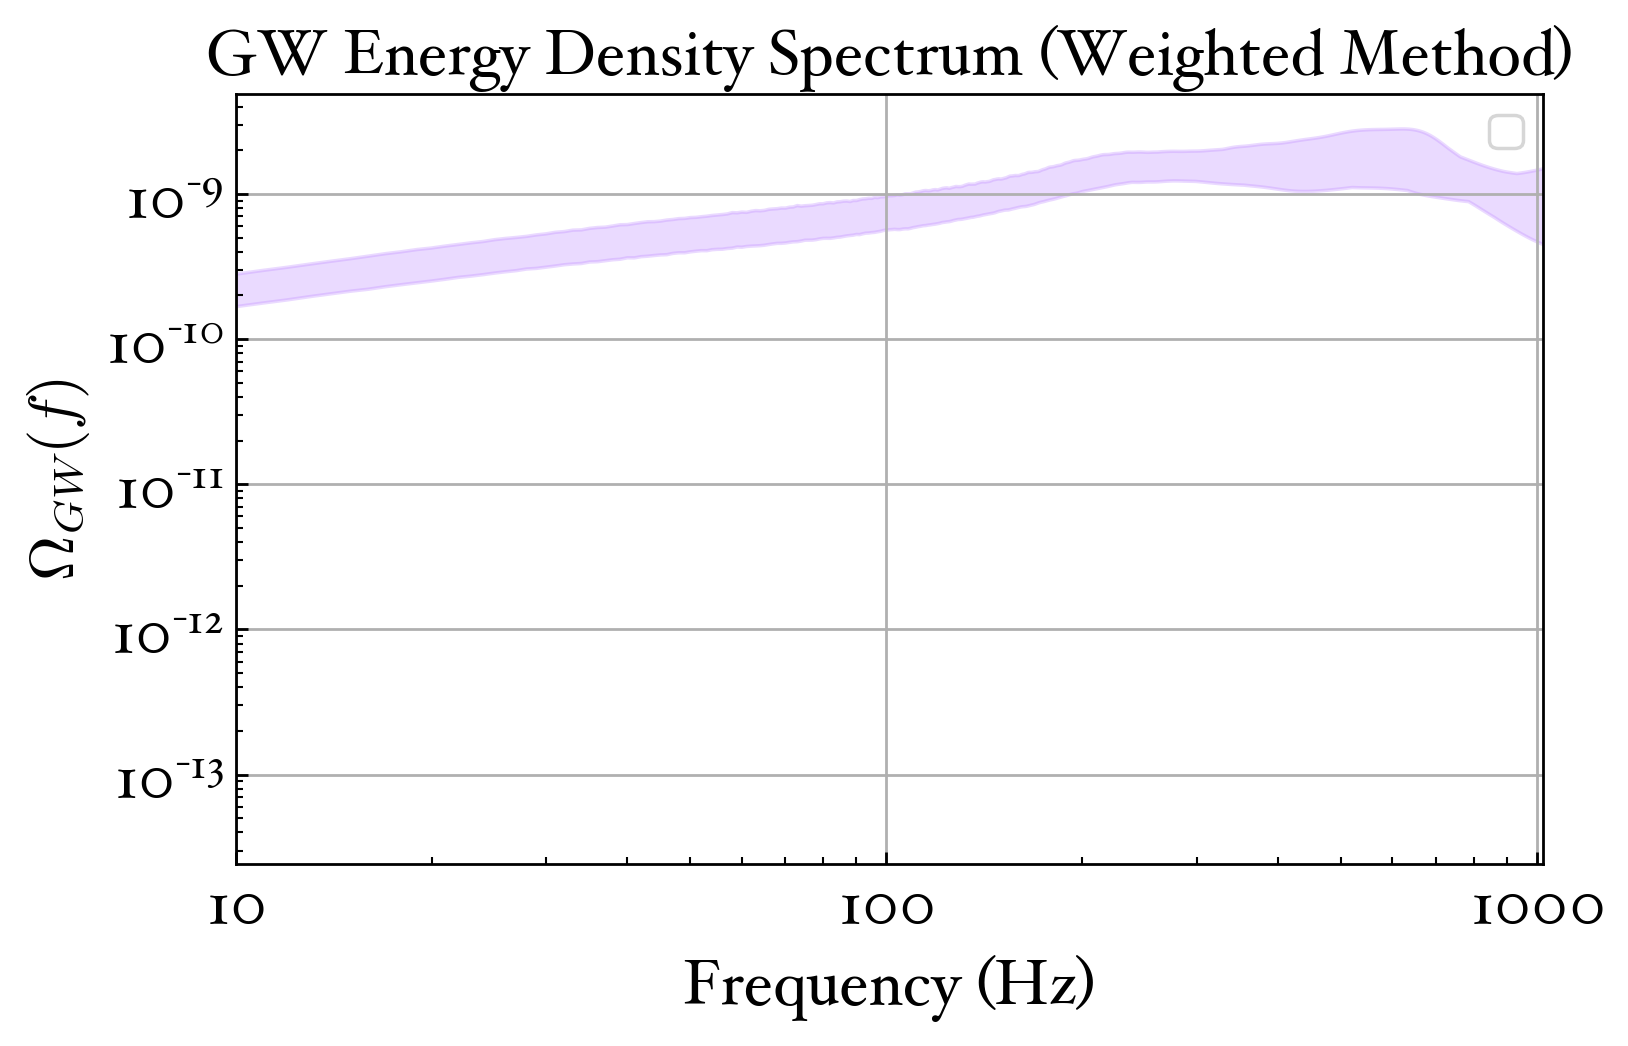

In [21]:
# Weighted Method
OmegaGW_Ws = []

# "reference" prior dictionary
ref_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# uniform_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
ref_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
ref_priors['chi_1'] = 0
ref_priors['chi_2'] = 0
ref_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp,
                                                                       minimum=0, maximum=z_max, name='redshift')
ref_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del ref_priors['luminosity_distance']
del ref_priors['chirp_mass']

for i in range(num_iterations):
   # Draw samples
    N_inj = np.random.poisson(N.value)
    injections = ref_priors.sample(N_inj)

    m1s = injections['mass_1']
    qs = injections['mass_ratio']
    zs = injections['redshift']
    m2s = []
    Mtots = [] # m1 + m2
    Ms = [] # chirp masses
    for i in range(len(injections['mass_1'])):
        m2s.append(equations.calculate_m2(m1s[i], qs[i]))
        Mtots.append(equations.calculate_Mtot(m1s[i], m2s[i]))
        Ms.append(equations.calculate_M(m1s[i], m2s[i]))

    # Set up waveform generator
    # Waveform generator parameters
    sampling_frequency=4096
    approximant='IMRPhenomXPHM'

    # Initialize waveform generator
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=1,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments={
            "waveform_approximant": approximant,
            "reference_frequency": 50,
            "minimum_frequency": 1
        }
    )

    # Calculate non-weighted dEdf from uniform distributions
    freqs_W = waveform_generator.frequency_array
    OmegaGW_W = np.zeros(len(freqs_W))

    dEdfs = []
    # for i in range(N_inj):
    for i in tqdm(range(N_inj)):
        inj_params = {}
        # Generate the individual parameters dictionary for each injection
        for k in injections.keys():
            if k == 'signal_type':
                continue
            try:
                inj_params[k] = injections[k]['content'][i]
            except:
                inj_params[k] = injections[k][i]

        # Get frequency domain waveform
        polarizations = waveform_generator.frequency_domain_strain(inj_params)

        # Final PSD of the injection
        dEdf = np.abs(polarizations['plus']) ** 2 + np.abs(polarizations['cross']) ** 2
        dEdfs.append(dEdf)
        
    # Calculate Omega(f)
    dEdf_sum = 0
    for i in range(N_inj):
        z = zs[i]
        m1 = m1s[i]
        m2 = m2s[i]
        q = qs[i]
        Mtot = Mtots[i]
        M = Ms[i]

        # Probability of drawing {z, m1, m2}
        p_z = priors['redshift'].prob(z)
        p_m1 = priors['mass_1'].prob(m1)
        p_q = priors['mass_ratio'].prob(q)

        pdraw_z = ref_priors['redshift'].prob(z)
        pdraw_m1 = ref_priors['mass_1'].prob(m1)
        pdraw_q = ref_priors['mass_ratio'].prob(q)

        # Weight calculation
        r = equations.R_SI(alpha, beta, z, zp, R0)
        h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
        h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

        wi = (p_z/pdraw_z) * (p_m1/pdraw_m1) * (p_q/pdraw_q)
        dEdf = wi*dEdfs[i]

        dEdf_sum += dEdf
        
        # Add to Omega_spectrum
        # OmegaGW_W += 2 * np.pi**2 * freqs_W**3 * dEdf / (3 * h0**2)
    OmegaGW_W = 2 * np.pi**2 * freqs_W**3 * dEdf_sum / (3 * h0**2)
    Tobs_seconds = T_obs * 86400 * 365.25  # years to seconds
    OmegaGW_W *= 2 / Tobs_seconds

    OmegaGW_Ws.append(OmegaGW_W)

%matplotlib inline
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_W, np.percentile(OmegaGW_Ws, 5, axis=0), np.percentile(OmegaGW_Ws, 95, axis=0), color='#bc85ff', alpha=0.3)
ax.set_title(r'GW Energy Density Spectrum (Weighted Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1024)
ax.legend()


/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_39382/2715112410.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


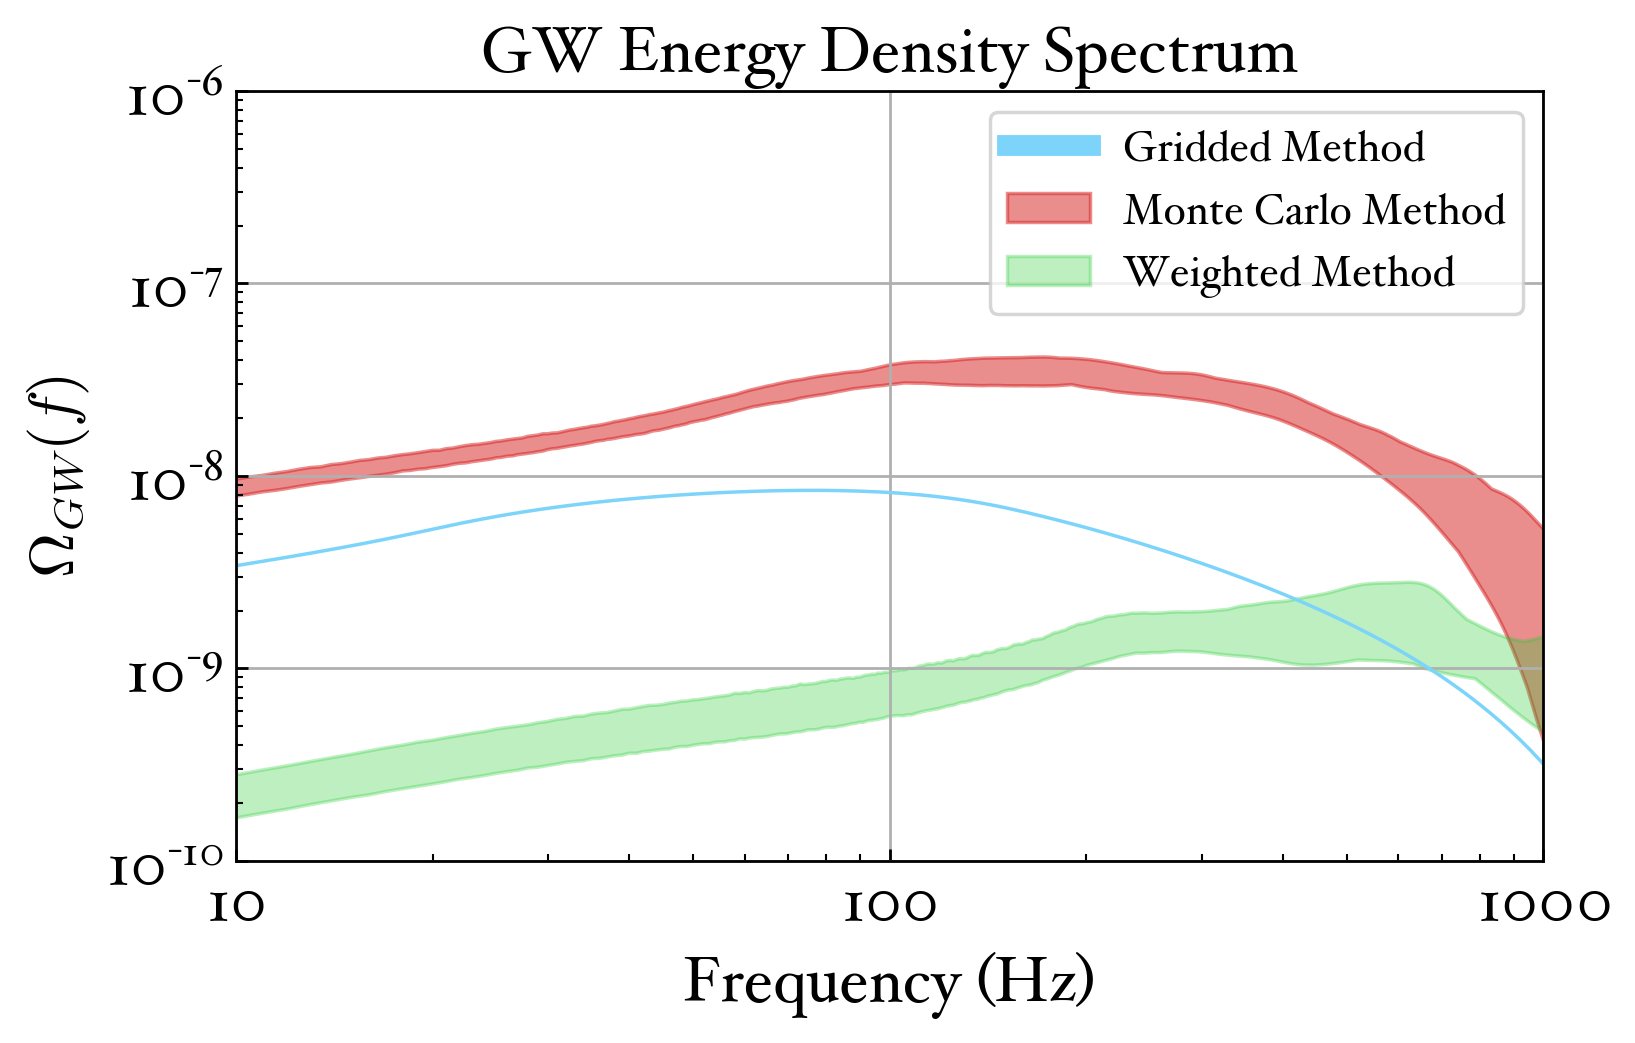

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', label='Gridded Method')
ax.fill_between(freqs_psd, np.percentile(OmegaGW_AR, 5, axis=0), np.percentile(OmegaGW_AR, 95, axis=0), color='#d61c1c', label='Monte Carlo Method', alpha=0.5)
# ax.fill_between(total_freqs_CB, np.percentile(total_OmegaGW_CB, 5), np.percentile(total_OmegaGW_CB, 95), color='#25cc33', label='Combined Method', alpha=0.5)
ax.fill_between(freqs_W, np.percentile(OmegaGW_Ws, 5, axis=0), np.percentile(OmegaGW_Ws, 95, axis=0), color='#25cc33', label='Weighted Method', alpha=0.3)
# ax.loglog(total_freqs_AR, Omega_ref_AR*(total_freqs_AR/fref)**(2/3), label='2/3 Power Law (Regimbau)', color='#991414')
# ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law (Callister)', color='#1f769c')
# ax.loglog(freqs_CB, Omega_ref_CB*(np.array(freqs_CB)/fref)**(2/3), label='2/3 Power Law (Combined)', color='#14751c')
ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.set_ylim(1e-10, 1e-6)
ax.legend()
fig.show()

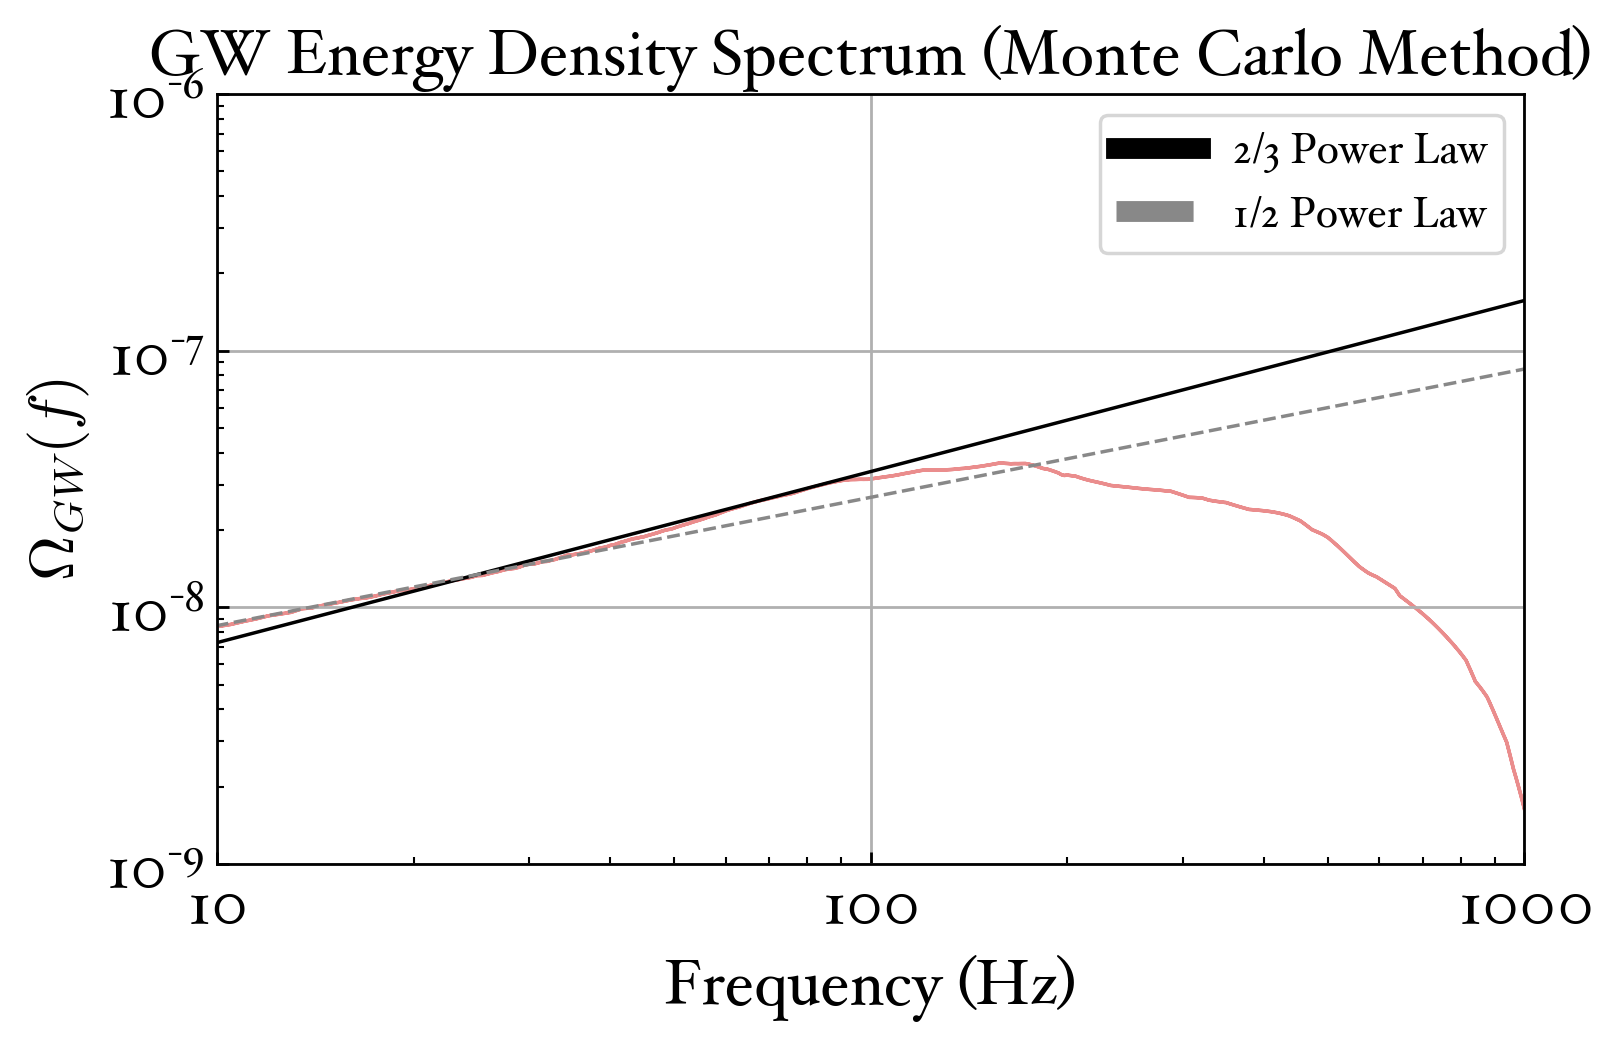

In [23]:
# Plot spectrum
# Find OmegaGW(fref)
fref = 25
fref_approx_AR = 100
fref_approx_index_AR = 0
for i in range(len(freqs_psd)):
    if(np.absolute(freqs_psd[i] - fref) < fref_approx_AR):
        fref_approx_AR = np.absolute(freqs_psd[i] - fref)
        fref_approx_index_AR = i
Omega_ref_AR = np.sum(OmegaGW_AR, axis=0)[fref_approx_index_AR]
diff = (Omega_ref_AR*np.divide(freqs_psd,fref)**(2/3))[50]-np.percentile(OmegaGW_AR, 50, axis=0)[50]
diff = diff*np.ones(len(freqs_psd))
plt.subplots()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_psd, np.percentile(OmegaGW_AR, 50, axis=0), np.percentile(OmegaGW_AR, 50, axis=0), color='#d61c1c', alpha=0.5)
ax.loglog(freqs_psd, Omega_ref_AR*np.divide(freqs_psd,fref)**(2/3)/10, '-', label='2/3 Power Law', color='#000000')
ax.loglog(freqs_psd, Omega_ref_AR*np.divide(freqs_psd,fref)**(1/2)/10, '--', label='1/2 Power Law', color='#888888')
ax.set_xlim(10, 1000)
ax.set_ylim(1e-9,1e-6)
ax.set_title(r'GW Energy Density Spectrum (Monte Carlo Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.legend()

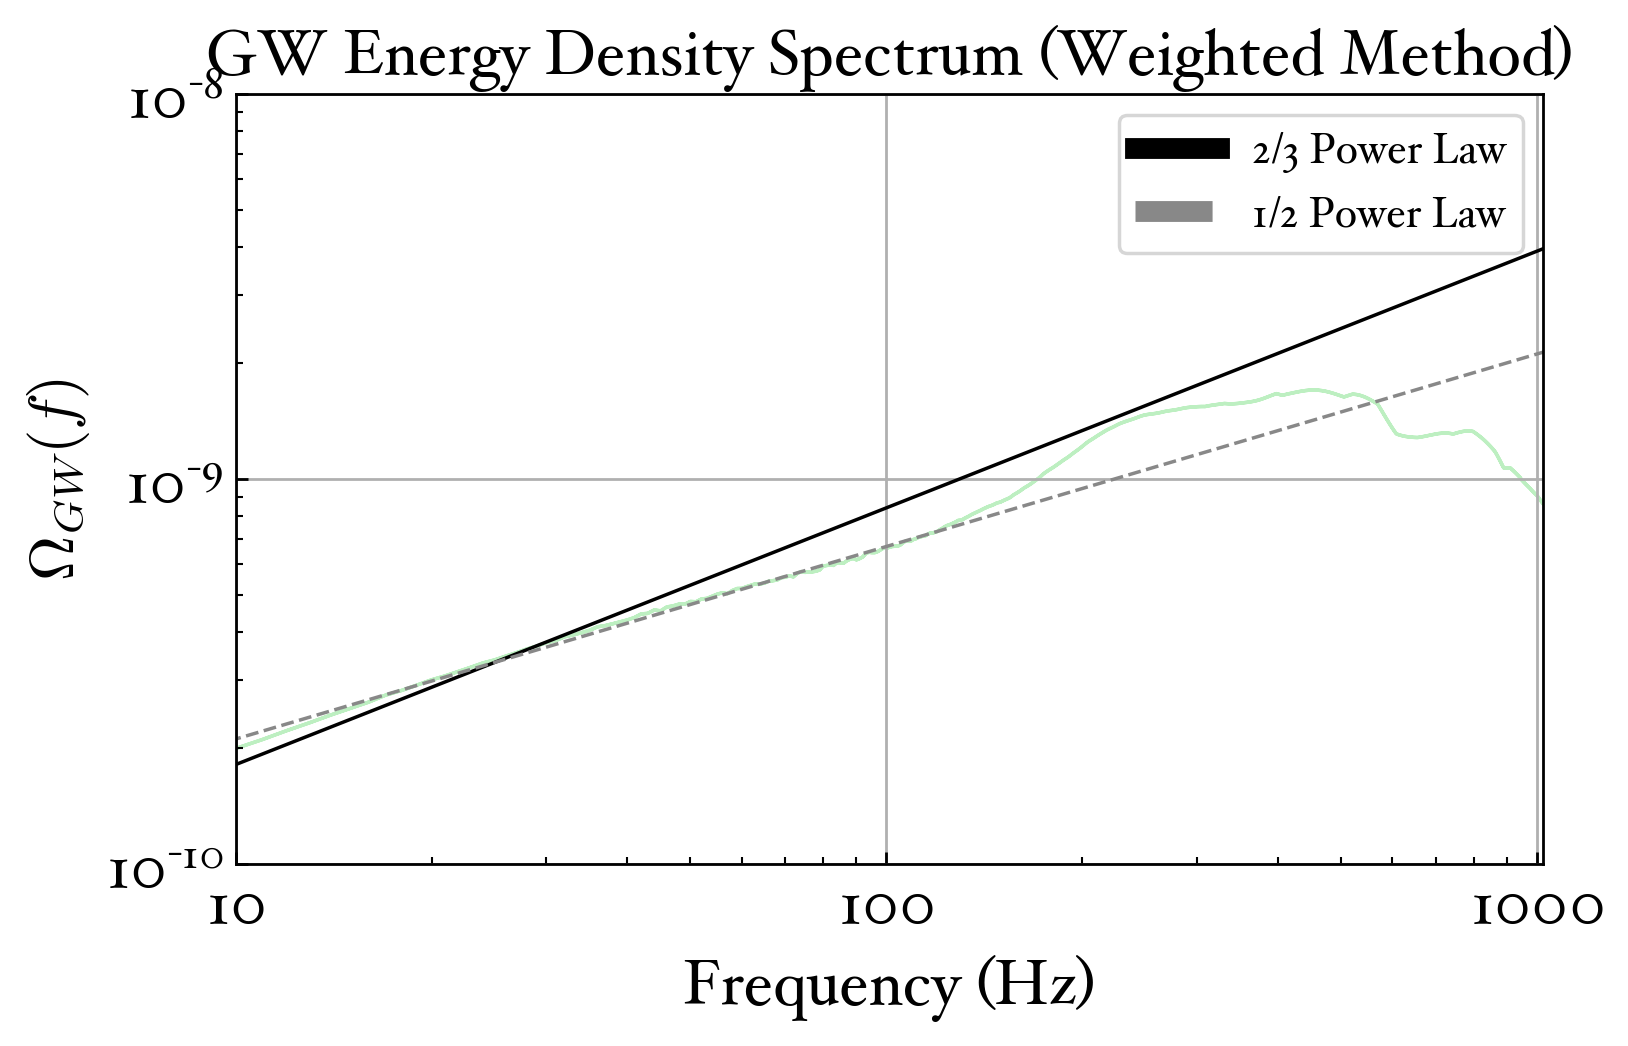

In [34]:
fref = 25
fref_approx_W = 100
fref_approx_index_W = 0
for i in range(len(freqs_W)):
    if(np.absolute(freqs_W[i] - fref) < fref_approx_W):
        fref_approx_W = np.absolute(freqs_W[i] - fref)
        fref_approx_index_W = i
Omega_ref_W = np.sum(OmegaGW_Ws, axis=0)[fref_approx_index_W]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_W, np.percentile(OmegaGW_Ws, 50, axis=0), np.percentile(OmegaGW_Ws, 50, axis=0), color='#25cc33', alpha=0.3)
ax.loglog(freqs_W, Omega_ref_W*np.divide(freqs_W,fref)**(2/3)/11, '-', label='2/3 Power Law', color='#000000')
ax.loglog(freqs_W, Omega_ref_W*np.divide(freqs_W,fref)**(1/2)/11, '--', label='1/2 Power Law', color='#888888')
ax.set_title(r'GW Energy Density Spectrum (Weighted Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1024)
ax.set_ylim(1e-10,1e-8)
ax.legend()